In [1]:
from tqdm import tqdm
from skimage.io import imread
from skimage import color
from scipy.misc import imresize
from scipy import fftpack
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

%matplotlib inline
np.seterr(divide='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from utils import get_labels_dict
from constants import LABELS, WEATHER_IDX
from datasets.image_generation import ImageDataGenerator
WEATHER_LABELS = [LABELS[i] for i in WEATHER_IDX]
HSV = ["H", "S", "V"]
W, H, D = 256, 256, 3
W2, H2 = W//2, H//2

print(LABELS)
labels = get_labels_dict()

Using TensorFlow backend.


['clear', 'cloudy', 'haze', 'partly_cloudy', 'agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'conventional_mine', 'cultivation', 'habitation', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [3]:
def get_images_of_tag(tag, n):
    """
    Return n image with that match the tag
    """
    idx = LABELS.index(tag)
    for k in labels:
        if labels[k][idx] == 1:
            yield k
            n -= 1
            if n ==0:
                break
                
def show(img):
    s = img.shape
    if len(s) == 2:
        # grey scale
        img = img.reshape((s[0], s[1], 1))
        img = get_channels(img)[0]
    plt.imshow(np.asarray(img[:,:,0:D], dtype=np.uint8))
    plt.show()
    
def open_img(name):
    #return imread(name)
    #return 255 - np.asarray(Image.open(name, "r"), dtype=np.float32)[:,:,0:3]
    return 255 - np.asarray(Image.open(name, "r"), dtype=np.uint8)[:,:,0:D]


['clear', 'artisinal_mine', 'bare_ground', 'primary', 'road', 'water']


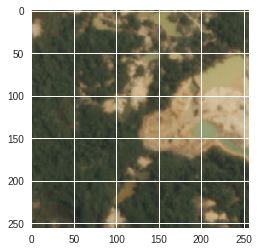

In [31]:
gen = get_images_of_tag("artisinal_mine", 100)
for i in range(25):
    next(gen)
img_name = next(gen)
print([LABELS[i] for i, v in enumerate(labels[img_name]) if v == 1])
img_path = "rawInput/train-jpg/{name}.jpg".format(name=img_name)
img = open_img(img_path)
show(img)

In [5]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.5
        sigma = var**0.5 * 10
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                        for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                        for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

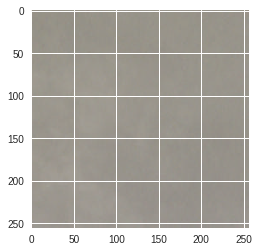

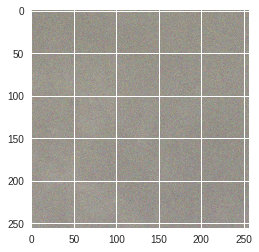

(None, None)

In [6]:
show(img), show(noisy("gauss", img))

In [118]:
"""Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
"""
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading
import warnings
import multiprocessing.pool
from functools import partial

from keras import backend as K

try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None


def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.pi / 180 * np.random.uniform(-rg, rg)
    rotation_matrix = np.array([[np.cos(theta) * 0.5, -np.sin(theta) * 0.5, 0],
                                [np.sin(theta) * 0.5, np.cos(theta) * 0.5, 0],
                                [0, 0, 1]]) 

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shear of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Sheared Numpy image tensor.
    """
    shear = np.random.uniform(-intensity, intensity)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):
    """Performs a random spatial zoom of a Numpy image tensor.

    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        Zoomed Numpy image tensor.

    # Raises
        ValueError: if `zoom_range` isn't a tuple.
    """
    if len(zoom_range) != 2:
        raise ValueError('zoom_range should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_channel_shift(x, intensity, channel_axis=0):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.

    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].

    # Returns
        A PIL Image instance.

    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.

    # Arguments
        img: PIL Image instance.
        data_format: Image data format.

    # Returns
        A 3D Numpy array.

    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x


def load_img(path, grayscale=False, target_size=None):
    """Loads an image into PIL format.

    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.

    # Returns
        A PIL Image instance.

    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img


def list_pictures(directory, ext='jpg|jpeg|bmp|png'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]


class ImageDataGenerator(object):
    """Generate minibatches of image data with real-time data augmentation.

    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        rotation_range: degrees (0 to 180).
        width_shift_range: fraction of total width.
        height_shift_range: fraction of total height.
        shear_range: shear intensity (shear angle in radians).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channels.
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally.
        vertical_flip: whether to randomly flip images vertically.
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run before any other modification on it.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
            (the depth) is at index 1, in 'channels_last' mode it is at index 3.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('data_format should be "channels_last" (channel after row and '
                             'column) or "channels_first" (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('zoom_range should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='png'):
        return NumpyArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=32, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False):
        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.

        # Arguments
            x: batch of inputs to be normalized.

        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) + 1e-7)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (x.size))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x):
        """Randomly augment a single image tensor.

        # Arguments
            x: 3D tensor, single image.

        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

        transform_matrix = None
        if theta != 0:
            s = np.sin(theta)
            c = np.cos(theta)
            f = 1 / max(abs(c - s), abs(c + s))
            rotation_matrix = np.array([[np.cos(theta) / f, -np.sin(theta) / f, 0],
                                        [np.sin(theta) / f, np.cos(theta) / f, 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        return x

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.

        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.

        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.

        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {3, 4}:
            warnings.warn(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + self.zca_epsilon))), u.T)


class Iterator(object):
    """Abstract base class for image data iterators.

    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.

    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            raise ValueError('NumpyArrayIterator is set to use the '
                             'data format convention "' + data_format + '" '
                             '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                             'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                             'However, it was passed an array with shape ' + str(self.x.shape) +
                             ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y


def _count_valid_files_in_directory(directory, white_list_formats, follow_links):
    """Count files with extension in `white_list_formats` contained in a directory.

    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.

    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    def _recursive_list(subpath):
        return sorted(os.walk(subpath, followlinks=follow_links), key=lambda tpl: tpl[0])

    samples = 0
    for root, _, files in _recursive_list(directory):
        for fname in files:
            is_valid = False
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
                samples += 1
    return samples


def _list_valid_filenames_in_directory(directory, white_list_formats,
                                       class_indices, follow_links):
    """List paths of files in `subdir` relative from `directory` whose extensions are in `white_list_formats`.

    # Arguments
        directory: absolute path to a directory containing the files to list.
            The directory name is used as class label and must be a key of `class_indices`.
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        class_indices: dictionary mapping a class name to its index.

    # Returns
        classes: a list of class indices
        filenames: the path of valid files in `directory`, relative from
            `directory`'s parent (e.g., if `directory` is "dataset/class1",
            the filenames will be ["class1/file1.jpg", "class1/file2.jpg", ...]).
    """
    def _recursive_list(subpath):
        return sorted(os.walk(subpath, followlinks=follow_links), key=lambda tpl: tpl[0])

    classes = []
    filenames = []
    subdir = os.path.basename(directory)
    basedir = os.path.dirname(directory)
    for root, _, files in _recursive_list(directory):
        for fname in files:
            is_valid = False
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
                classes.append(class_indices[subdir])
                # add filename relative to directory
                absolute_path = os.path.join(root, fname)
                filenames.append(os.path.relpath(absolute_path, basedir))
    return classes, filenames


class DirectoryIterator(Iterator):
    """Iterator capable of reading images from a directory on disk.

    # Arguments
        directory: Path to the directory to read images from.
            Each subdirectory in this directory will be
            considered to contain images from one class,
            or alternatively you could specify class subdirectories
            via the `classes` argument.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        target_size: tuple of integers, dimensions to resize input images to.
        color_mode: One of `"rgb"`, `"grayscale"`. Color mode to read images.
        classes: Optional list of strings, names of sudirectories
            containing images from each class (e.g. `["dogs", "cats"]`).
            It will be computed automatically if not set.
        class_mode: Mode for yielding the targets:
            `"binary"`: binary targets (if there are only two classes),
            `"categorical"`: categorical targets,
            `"sparse"`: integer targets,
            `"input"`: targets are images identical to input images (mainly
                used to work with autoencoders),
            `None`: no targets get yielded (only input images are yielded).
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, directory, image_data_generator,
                 target_size=(256, 256), color_mode='rgb',
                 classes=None, class_mode='categorical',
                 batch_size=32, shuffle=True, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 follow_links=False):
        if data_format is None:
            data_format = K.image_data_format()
        self.directory = directory
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        self.data_format = data_format
        if self.color_mode == 'rgb':
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size
        self.classes = classes
        if class_mode not in {'categorical', 'binary', 'sparse',
                              'input', None}:
            raise ValueError('Invalid class_mode:', class_mode,
                             '; expected one of "categorical", '
                             '"binary", "sparse", "input"'
                             ' or None.')
        self.class_mode = class_mode
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        white_list_formats = {'png', 'jpg', 'jpeg', 'bmp'}

        # first, count the number of samples and classes
        self.samples = 0

        if not classes:
            classes = []
            for subdir in sorted(os.listdir(directory)):
                if os.path.isdir(os.path.join(directory, subdir)):
                    classes.append(subdir)
        self.num_class = len(classes)
        self.class_indices = dict(zip(classes, range(len(classes))))

        def _recursive_list(subpath):
            return sorted(os.walk(subpath, followlinks=follow_links), key=lambda tpl: tpl[0])

        pool = multiprocessing.pool.ThreadPool()
        function_partial = partial(_count_valid_files_in_directory,
                                   white_list_formats=white_list_formats,
                                   follow_links=follow_links)
        self.samples = sum(pool.map(function_partial,
                                    (os.path.join(directory, subdir)
                                     for subdir in classes)))

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_class))

        # second, build an index of the images in the different class subfolders
        results = []

        self.filenames = []
        self.classes = np.zeros((self.samples,), dtype='int32')
        i = 0
        for dirpath in (os.path.join(directory, subdir) for subdir in classes):
            results.append(pool.apply_async(_list_valid_filenames_in_directory,
                                            (dirpath, white_list_formats,
                                             self.class_indices, follow_links)))
        for res in results:
            classes, filenames = res.get()
            self.classes[i:i + len(classes)] = classes
            self.filenames += filenames
            i += len(classes)
        pool.close()
        pool.join()
        super(DirectoryIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros((current_batch_size,) + self.image_shape, dtype=K.floatx())
        grayscale = self.color_mode == 'grayscale'
        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(os.path.join(self.directory, fname),
                           grayscale=grayscale,
                           target_size=self.target_size)
            x = img_to_array(img, data_format=self.data_format)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x
        return batch_x, batch_y

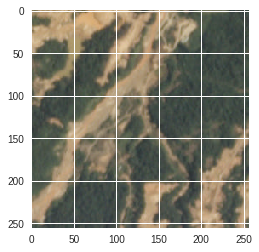

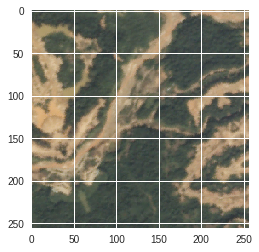

(None, None)

In [122]:
image_data_generator = ImageDataGenerator(
  # featurewise_center=False,
  # samplewise_center=False,
  # featurewise_std_normalization=False,
  # samplewise_std_normalization=False,
  # zca_whitening=False,
  rotation_range=180,
  # width_shift_range=0.,
  # height_shift_range=0.,
  # shear_range=0.,
  # zoom_range=0.,
  # channel_shift_range=0.,
  fill_mode='reflect', # 'constant', 'nearest', 'reflect' or 'wrap'
  # cval=0.,
  horizontal_flip=True,
  vertical_flip=True,
  # rescale=None,
  # preprocessing_function=None
)
img2 = image_data_generator.random_transform(img)
show(img), show(img2)